In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import logging
from datetime import datetime

logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

In [2]:
data=pd.read_csv("cfpb_data_with_clean_zip.csv")
print(data.head())

  Date.received                                            Product  \
0      12/07/21                                           Mortgage   
1      07/22/22                                    Debt collection   
2      10/27/21  Credit reporting, credit repair services, or o...   
3      01/05/19  Credit reporting, credit repair services, or o...   
4      11/08/20  Credit reporting, credit repair services, or o...   

        Sub.product                                              Issue  \
0       VA mortgage                     Trouble during payment process   
1         Auto debt                              Communication tactics   
2  Credit reporting  Problem with a credit reporting company's inve...   
3  Credit reporting               Incorrect information on your report   
4  Credit reporting               Incorrect information on your report   

                              Sub.issue Consumer.complaint.narrative  \
0                                  None                       

In [3]:
small_data = data.head(20000)
small_data.to_csv('small_complaints.csv', index=False)

In [4]:
data.info()
data['Date.received'] = pd.to_datetime(data['Date.received'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2036509 entries, 0 to 2036508
Data columns (total 21 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   Date.received                 object 
 1   Product                       object 
 2   Sub.product                   object 
 3   Issue                         object 
 4   Sub.issue                     object 
 5   Consumer.complaint.narrative  object 
 6   Company.public.response       object 
 7   Company                       object 
 8   State                         object 
 9   ZIP.code                      object 
 10  Tags                          object 
 11  Consumer.consent.provided.    object 
 12  Submitted.via                 object 
 13  Date.sent.to.company          object 
 14  Company.response.to.consumer  object 
 15  Timely.response.              object 
 16  Consumer.disputed.            float64
 17  Complaint.ID                  int64  
 18  zip_best              

In [ ]:
product_counts = data['Product'].value_counts()
product_counts_df = product_counts.reset_index().rename(columns={'index': 'Product', 'Product': 'Count'})

print(product_counts_df)

In [ ]:
product_counts = data['Sub.product'].value_counts()
product_counts_df = product_counts.reset_index().rename(columns={'index': 'Sub product', 'Sub.Product': 'Count'})

print(product_counts_df)

/Users/jim.mcgarr/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


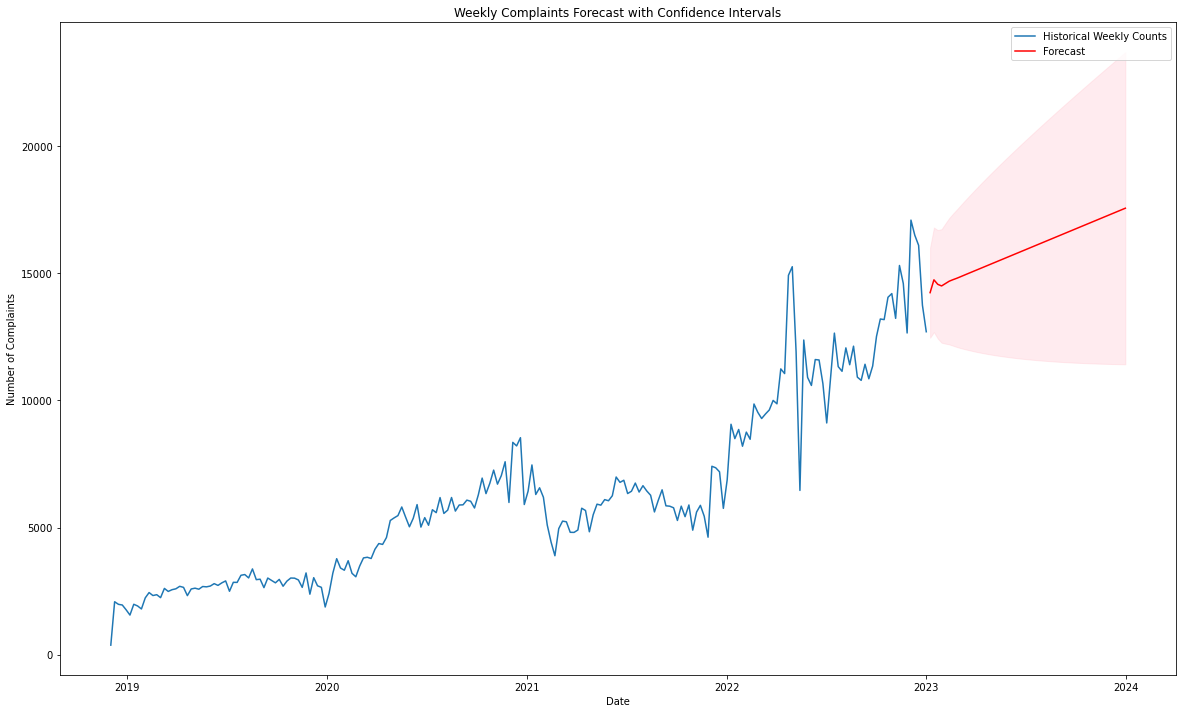

In [5]:
#ARIMA

from statsmodels.tsa.arima.model import ARIMA

#start with "Credit reporting..."
filtered_data = data[data['Product'] == 'Credit reporting, credit repair services, or other personal consumer reports']

# Aggregate complaints by week
weekly_counts = filtered_data.resample('W', on='Date.received').size()

model = ARIMA(weekly_counts, order=(2,2,2))  #tuned below
model_fit = model.fit()

#print(model_fit.summary())

# visualize forecast

# Forecast the next 12 weeks
forecast_result = model_fit.get_forecast(steps=52)
predicted_means = forecast_result.predicted_mean
confidence_intervals = forecast_result.conf_int()

# Extract the lower and upper bounds
lower_bounds = confidence_intervals['lower y']
upper_bounds = confidence_intervals['upper y']

plt.figure(figsize=(20, 12))
plt.plot(weekly_counts.index, weekly_counts, label='Historical Weekly Counts')
plt.plot(predicted_means.index, predicted_means, color='red', label='Forecast')
plt.fill_between(predicted_means.index, lower_bounds, upper_bounds, color='pink', alpha=0.3)

plt.title('Weekly Complaints Forecast with Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('Number of Complaints')
plt.legend()
plt.show()


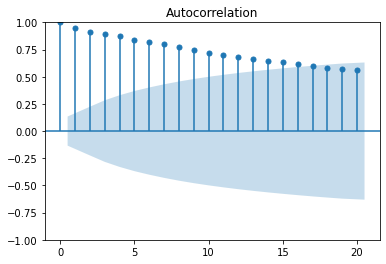

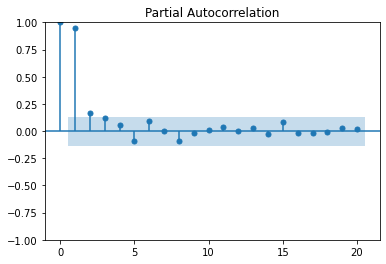

In [6]:
# tune the order parameters

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
plot_acf(weekly_counts, lags=20)
plot_pacf(weekly_counts, lags=20, method='ywm')

plt.show()

In [7]:
import itertools
import warnings
from statsmodels.tsa.arima.model import ARIMA

p = d = q = range(0, 3)  # Adjust ranges as needed based on ACF and PACF plots
pdq = list(itertools.product(p, d, q))

lowest_aic = float("inf")
best_pdq = None
warnings.filterwarnings("ignore")  # Ignore warnings from statsmodels or convergence issues

for param in pdq:
    try:
        model_temp = ARIMA(weekly_counts, order=param)
        results_temp = model_temp.fit()
        
        if results_temp.aic < lowest_aic:
            lowest_aic = results_temp.aic
            best_pdq = param
            
    except:
        continue

print(f"Best ARIMA Model Order: {best_pdq} with AIC: {lowest_aic}")


Best ARIMA Model Order: (2, 2, 2) with AIC: 3502.981210793607


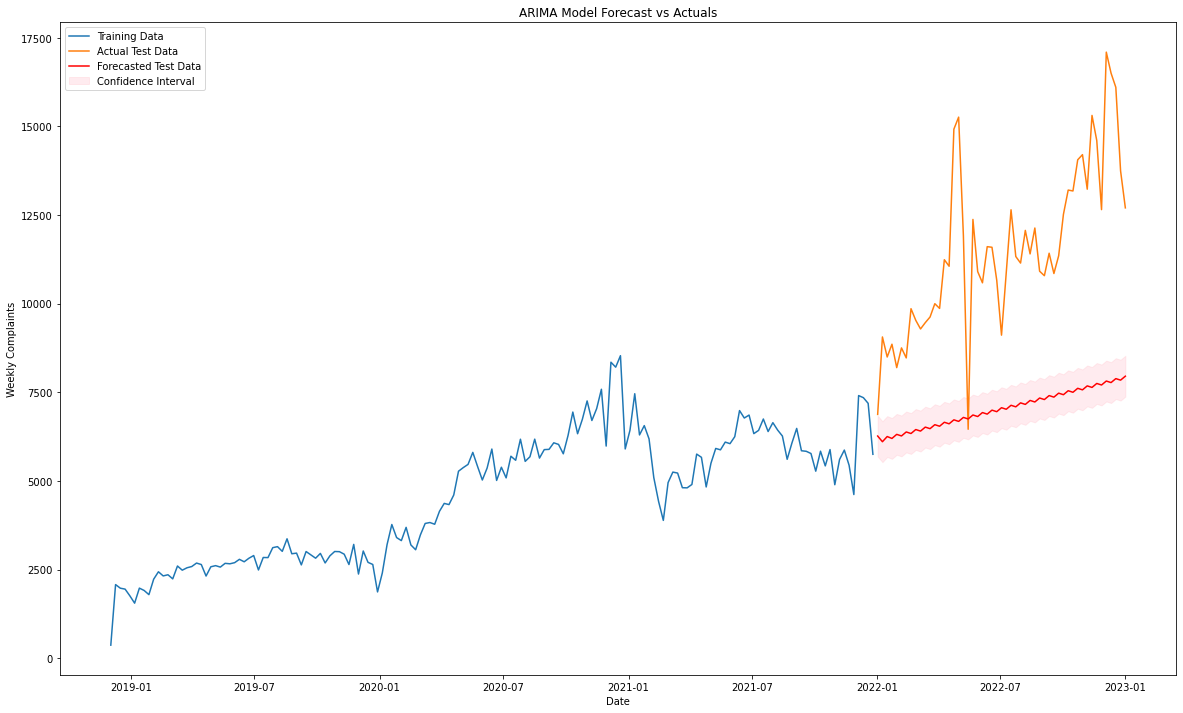

In [8]:
# ARIMA - using 2023 as a test set

train = weekly_counts[:'2021-12-31']
test = weekly_counts['2022-01-01':]

model = ARIMA(train, order=(2,2,2))
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=len(test))

# Comparing forecast against actual values
# Note: For detailed evaluation, consider calculating metrics like MAE, MSE, or RMSE
plt.figure(figsize=(20, 12))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual Test Data')
plt.plot(test.index, forecast, label='Forecasted Test Data', color='red')
plt.fill_between(test.index, forecast - model_fit.resid.std(), forecast + model_fit.resid.std(), color='pink', alpha=0.3, label='Confidence Interval')
plt.legend()
plt.title('ARIMA Model Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('Weekly Complaints')
plt.show()


# The real forecasting starts below here

In [9]:
# tricky install due to firewall
#!pip install prophet --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host files.pythonhosted.org

In [9]:
# ARIMA doesn't work even with tuned parameters. Following Suganya's (and chatgpt's ;-) ) suggestion to use Prophet

from prophet import Prophet

# First processing

prophet_df = weekly_counts.reset_index().rename(columns={'Date.received': 'ds', 0: 'y'})

train_prophet = prophet_df[prophet_df['ds'] < '2022-01-01']
test_prophet = prophet_df[prophet_df['ds'] >= '2022-01-01']

model_prophet = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
model_prophet.fit(train_prophet)

Importing plotly failed. Interactive plots will not work.
13:51:36 - cmdstanpy - INFO - Chain [1] start processing
13:51:37 - cmdstanpy - INFO - Chain [1] done processing


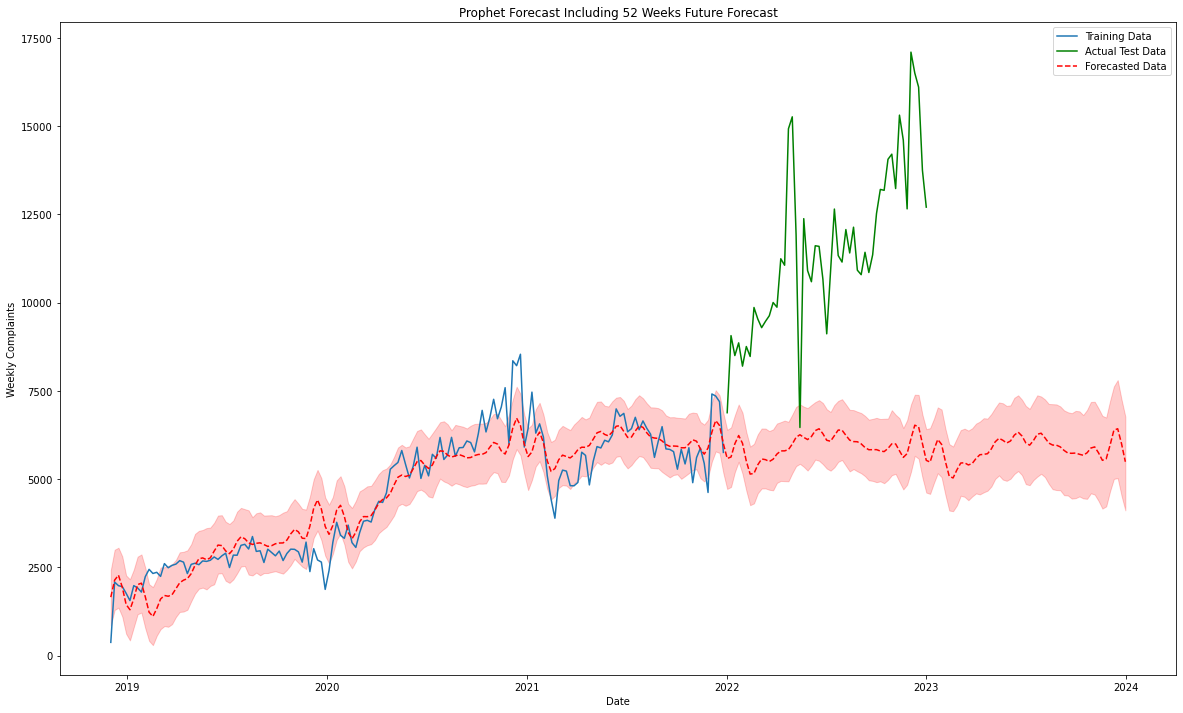

In [10]:
extended_future_dates = model_prophet.make_future_dataframe(periods=len(test_prophet) + 52, freq='W')
extended_forecast_prophet = model_prophet.predict(extended_future_dates)

# Plotting
fig, ax = plt.subplots(figsize=(20, 12))
ax.plot(train_prophet['ds'], train_prophet['y'], label='Training Data')
ax.plot(test_prophet['ds'], test_prophet['y'], label='Actual Test Data', color='green')
ax.plot(extended_future_dates['ds'], extended_forecast_prophet['yhat'], label='Forecasted Data', color='red', linestyle='--')

# Highlight the extended future forecast
ax.fill_between(extended_future_dates['ds'], extended_forecast_prophet['yhat_lower'], extended_forecast_prophet['yhat_upper'], color='red', alpha=0.2)

ax.set_title('Prophet Forecast Including 52 Weeks Future Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Weekly Complaints')
plt.legend()
plt.show()


13:51:38 - cmdstanpy - INFO - Chain [1] start processing
13:51:38 - cmdstanpy - INFO - Chain [1] done processing


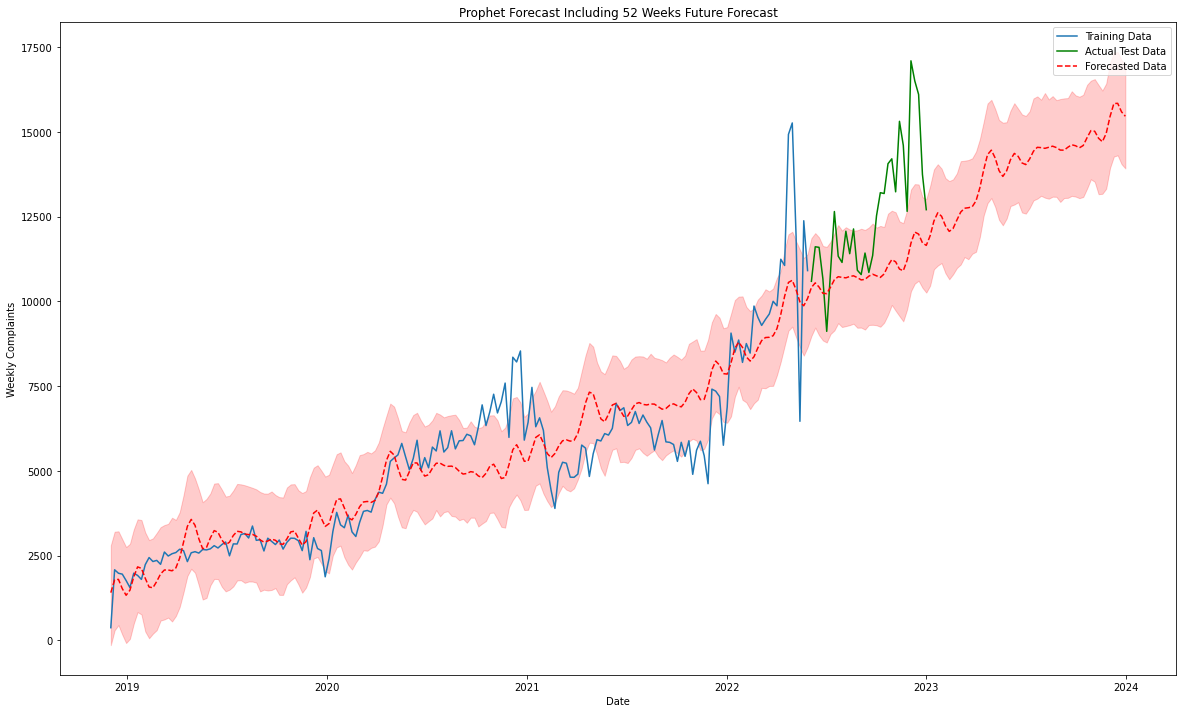

In [11]:
# Rerun w/ part of 2022 as training data

prophet_df = weekly_counts.reset_index().rename(columns={'Date.received': 'ds', 0: 'y'})

train_prophet = prophet_df[prophet_df['ds'] < '2022-06-01']
test_prophet = prophet_df[prophet_df['ds'] >= '2022-06-01']

model_prophet = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
model_prophet.fit(train_prophet)

extended_future_dates = model_prophet.make_future_dataframe(periods=len(test_prophet) + 52, freq='W')
extended_forecast_prophet = model_prophet.predict(extended_future_dates)

# Plotting
fig, ax = plt.subplots(figsize=(20, 12))
ax.plot(train_prophet['ds'], train_prophet['y'], label='Training Data')
ax.plot(test_prophet['ds'], test_prophet['y'], label='Actual Test Data', color='green')
ax.plot(extended_future_dates['ds'], extended_forecast_prophet['yhat'], label='Forecasted Data', color='red', linestyle='--')

# Highlight the extended future forecast
ax.fill_between(extended_future_dates['ds'], extended_forecast_prophet['yhat_lower'], extended_forecast_prophet['yhat_upper'], color='red', alpha=0.2)

ax.set_title('Prophet Forecast Including 52 Weeks Future Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Weekly Complaints')
plt.legend()
plt.show()

13:51:42 - cmdstanpy - INFO - Chain [1] start processing
13:51:42 - cmdstanpy - INFO - Chain [1] done processing


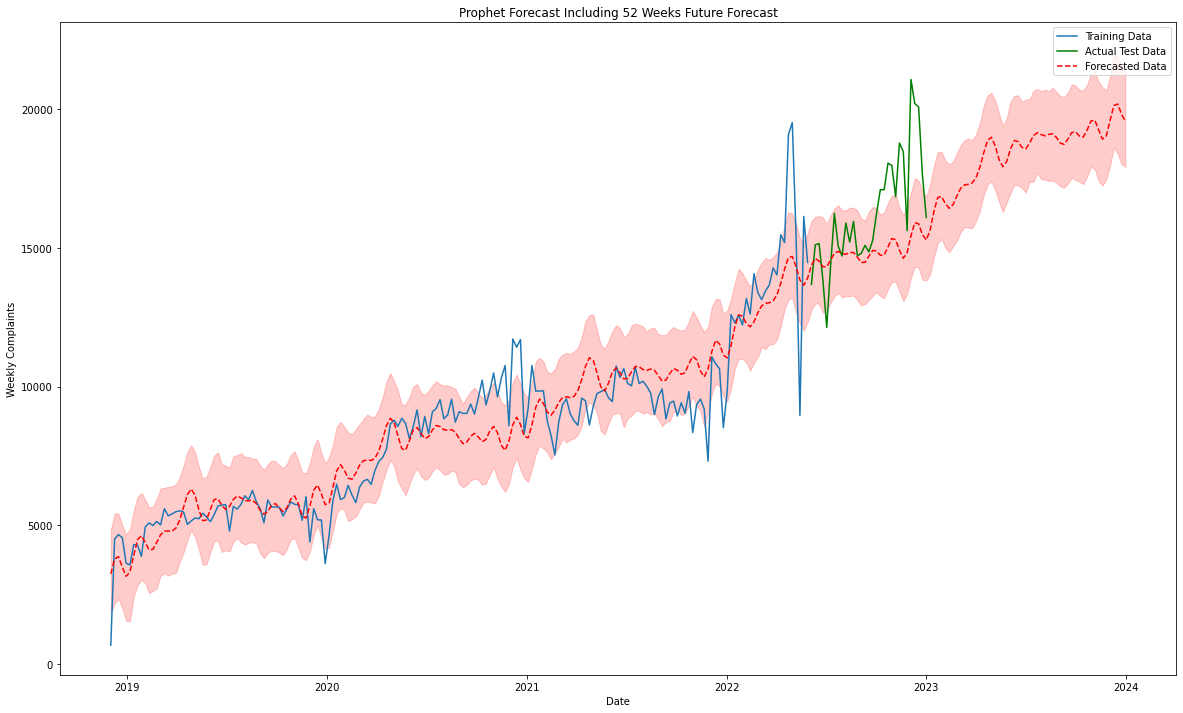

In [12]:
# Full sample of complaints

# Aggregate complaints by week
weekly_counts_full = data.resample('W', on='Date.received').size()

prophet_df = weekly_counts_full.reset_index().rename(columns={'Date.received': 'ds', 0: 'y'})

train_prophet = prophet_df[prophet_df['ds'] < '2022-06-01']
test_prophet = prophet_df[prophet_df['ds'] >= '2022-06-01']

model_prophet = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
model_prophet.fit(train_prophet)

extended_future_dates = model_prophet.make_future_dataframe(periods=len(test_prophet) + 52, freq='W')
extended_forecast_prophet = model_prophet.predict(extended_future_dates)

fig, ax = plt.subplots(figsize=(20, 12))
ax.plot(train_prophet['ds'], train_prophet['y'], label='Training Data')
ax.plot(test_prophet['ds'], test_prophet['y'], label='Actual Test Data', color='green')
ax.plot(extended_future_dates['ds'], extended_forecast_prophet['yhat'], label='Forecasted Data', color='red', linestyle='--')

# Highlight the extended future forecast
ax.fill_between(extended_future_dates['ds'], extended_forecast_prophet['yhat_lower'], extended_forecast_prophet['yhat_upper'], color='red', alpha=0.2)

ax.set_title('Prophet Forecast Including 52 Weeks Future Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Weekly Complaints')
plt.legend()
plt.show()

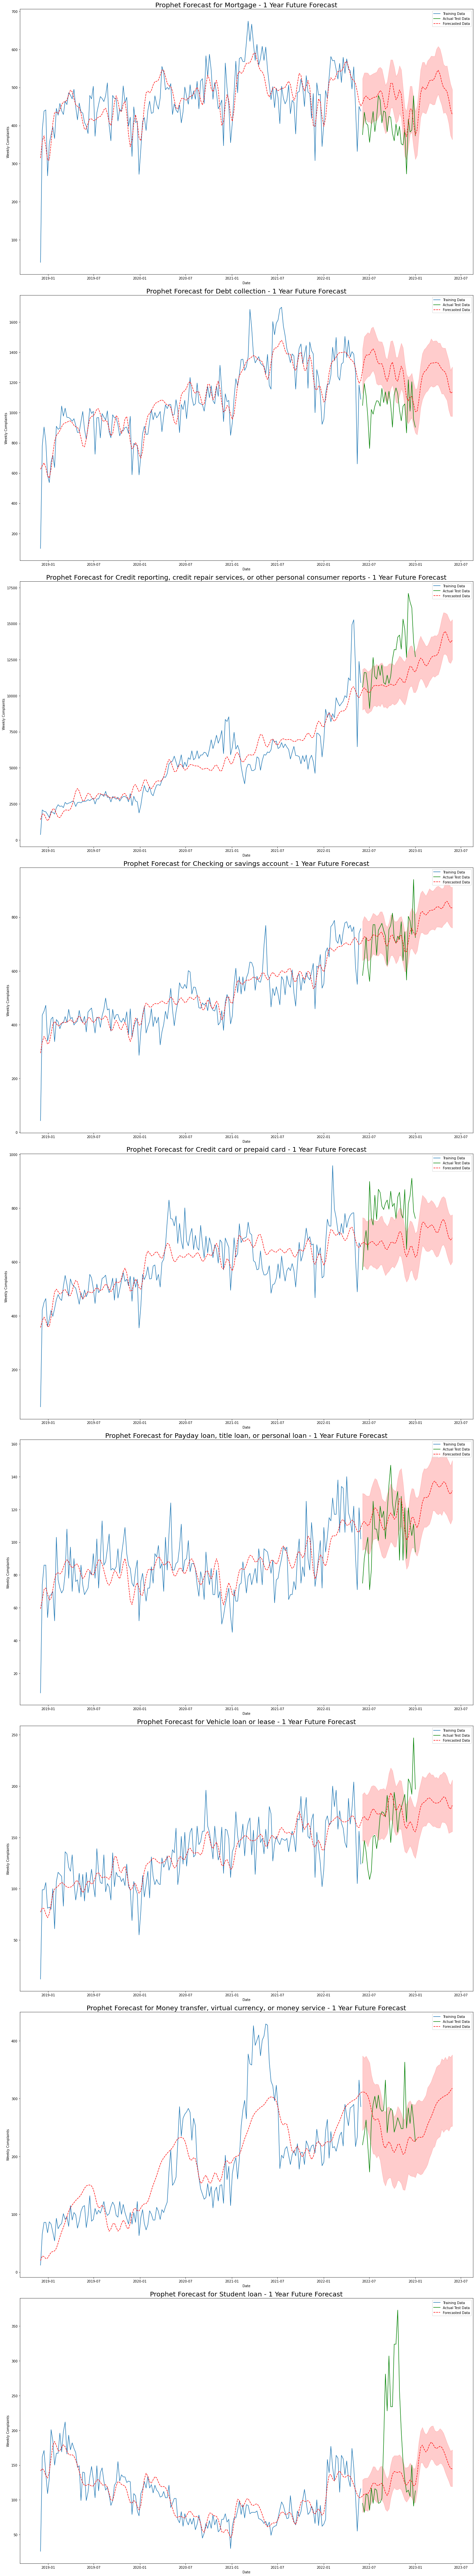

In [41]:
#### Run the prophet forecast for all 9 product types

product_types = data['Product'].unique()

# Create a figure for plotting
fig, axs = plt.subplots(len(product_types), 1, figsize=(20, 12*len(product_types)))
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

for i, product_type in enumerate(product_types):
    product_data = data[data['Product'] == product_type]
    
    weekly_counts = product_data.resample('W', on='Date.received').size().reset_index().rename(columns={0: 'y'})
    
    prophet_df = weekly_counts.rename(columns={'Date.received': 'ds', 'y': 'y'})
    train_prophet = prophet_df[prophet_df['ds'] < '2022-06-01']
    test_prophet = prophet_df[prophet_df['ds'] >= '2022-06-01']
    
    model_prophet = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
    model_prophet.fit(train_prophet)
    
    future_dates = model_prophet.make_future_dataframe(periods=52, freq='W')  # 52 weeks ahead for 1-year forecast
    forecast = model_prophet.predict(future_dates)
    
    # Plotting
    ax = axs[i]
    ax.plot(train_prophet['ds'], train_prophet['y'], label='Training Data')
    ax.plot(test_prophet['ds'], test_prophet['y'], label='Actual Test Data', color='green')
    ax.plot(future_dates['ds'], forecast['yhat'], label='Forecasted Data', color='red', linestyle='--')
    
    future_forecast_start = train_prophet['ds'].iloc[-1]
    future_idx = forecast['ds'] > future_forecast_start
    
    ax.fill_between(future_dates['ds'][future_idx], forecast['yhat_lower'][future_idx], forecast['yhat_upper'][future_idx], color='red', alpha=0.2)
    
    ax.set_title(f'Prophet Forecast for {product_type} - 1 Year Future Forecast', fontsize=20)
    ax.set_xlabel('Date')
    ax.set_ylabel('Weekly Complaints')
    ax.legend()

plt.tight_layout()
plt.show()


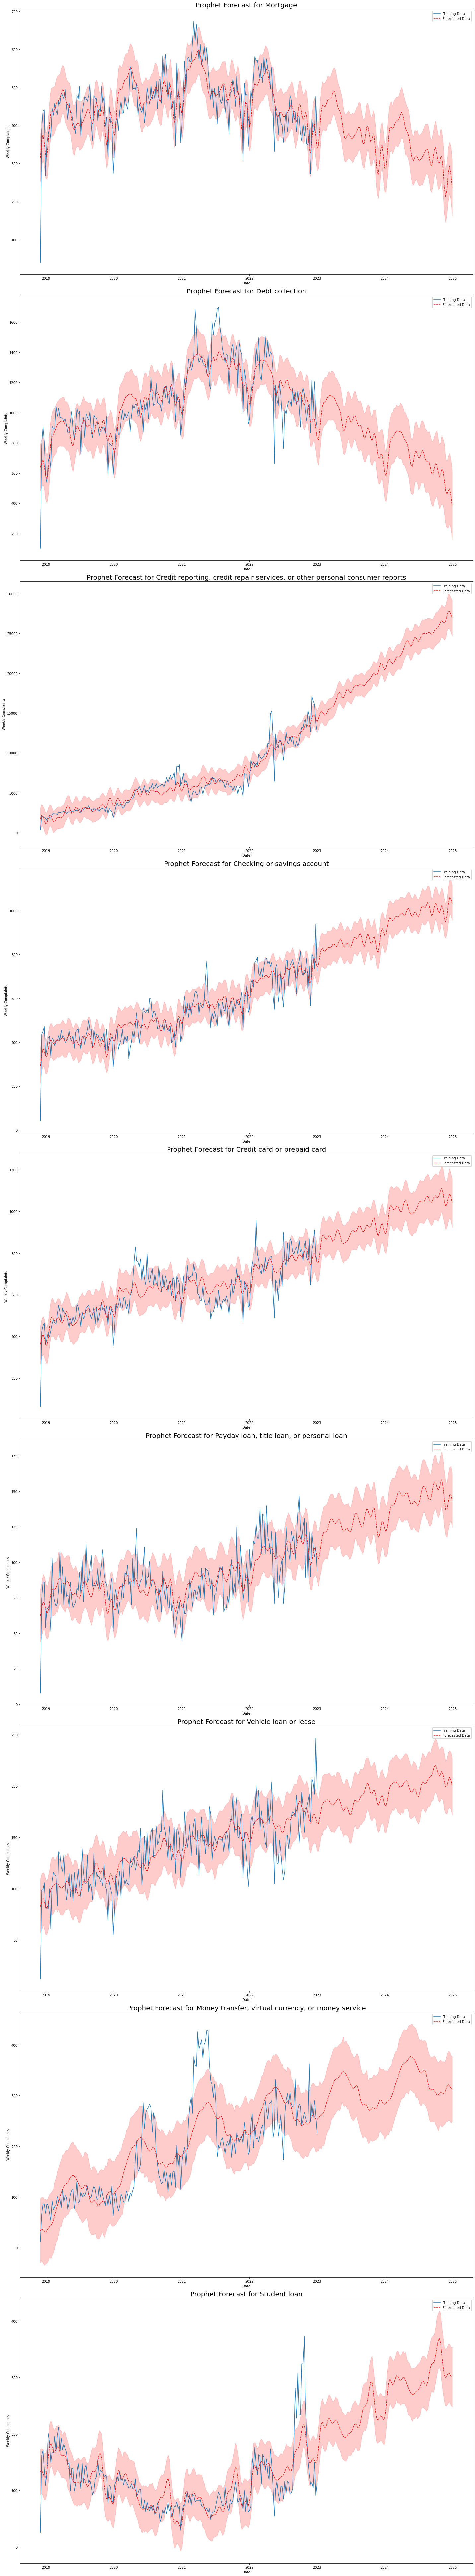

In [54]:
# Extend forecasts to 2023-2024, and output results

logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

all_forecasts = pd.DataFrame()

product_types = data['Product'].unique()

fig, axs = plt.subplots(len(product_types), 1, figsize=(20, 12 * len(product_types)))

for i, product_type in enumerate(product_types):
    product_data = data[data['Product'] == product_type]
    
    weekly_counts = product_data.resample('W', on='Date.received').size().reset_index().rename(columns={0: 'y'})
    weekly_counts.rename(columns={'Date.received': 'ds'}, inplace=True)
    
    model_prophet = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
    model_prophet.fit(weekly_counts)
    
    future_dates = model_prophet.make_future_dataframe(periods=104, freq='W')  
    forecast = model_prophet.predict(future_dates)
    forecast['product'] = product_type 

    forecast['week'] = (forecast['ds'] - pd.to_timedelta(forecast['ds'].dt.weekday, unit='d')).dt.strftime('%Y-%m-%d')

    forecast_filtered = forecast[(forecast['ds'] >= '2023-01-01') & (forecast['ds'] <= '2024-12-31')]

    forecast_filtered = forecast_filtered.head(104)

    all_forecasts = pd.concat([all_forecasts, forecast_filtered[['week', 'yhat', 'yhat_lower', 'yhat_upper', 'product']]])

    # Plotting
    ax = axs[i]
    ax.plot(weekly_counts['ds'], weekly_counts['y'], label='Training Data')
    ax.plot(forecast['ds'], forecast['yhat'], label='Forecasted Data', color='red', linestyle='--')
    ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='red', alpha=0.2)
    ax.set_title(f'Prophet Forecast for {product_type}', fontsize=20)
    ax.set_xlabel('Date')
    ax.set_ylabel('Weekly Complaints')
    ax.legend()

plt.tight_layout()
plt.show()

# Save the filtered forecast data to CSV
all_forecasts.to_csv('intermediate_forecasts.csv', index=False)



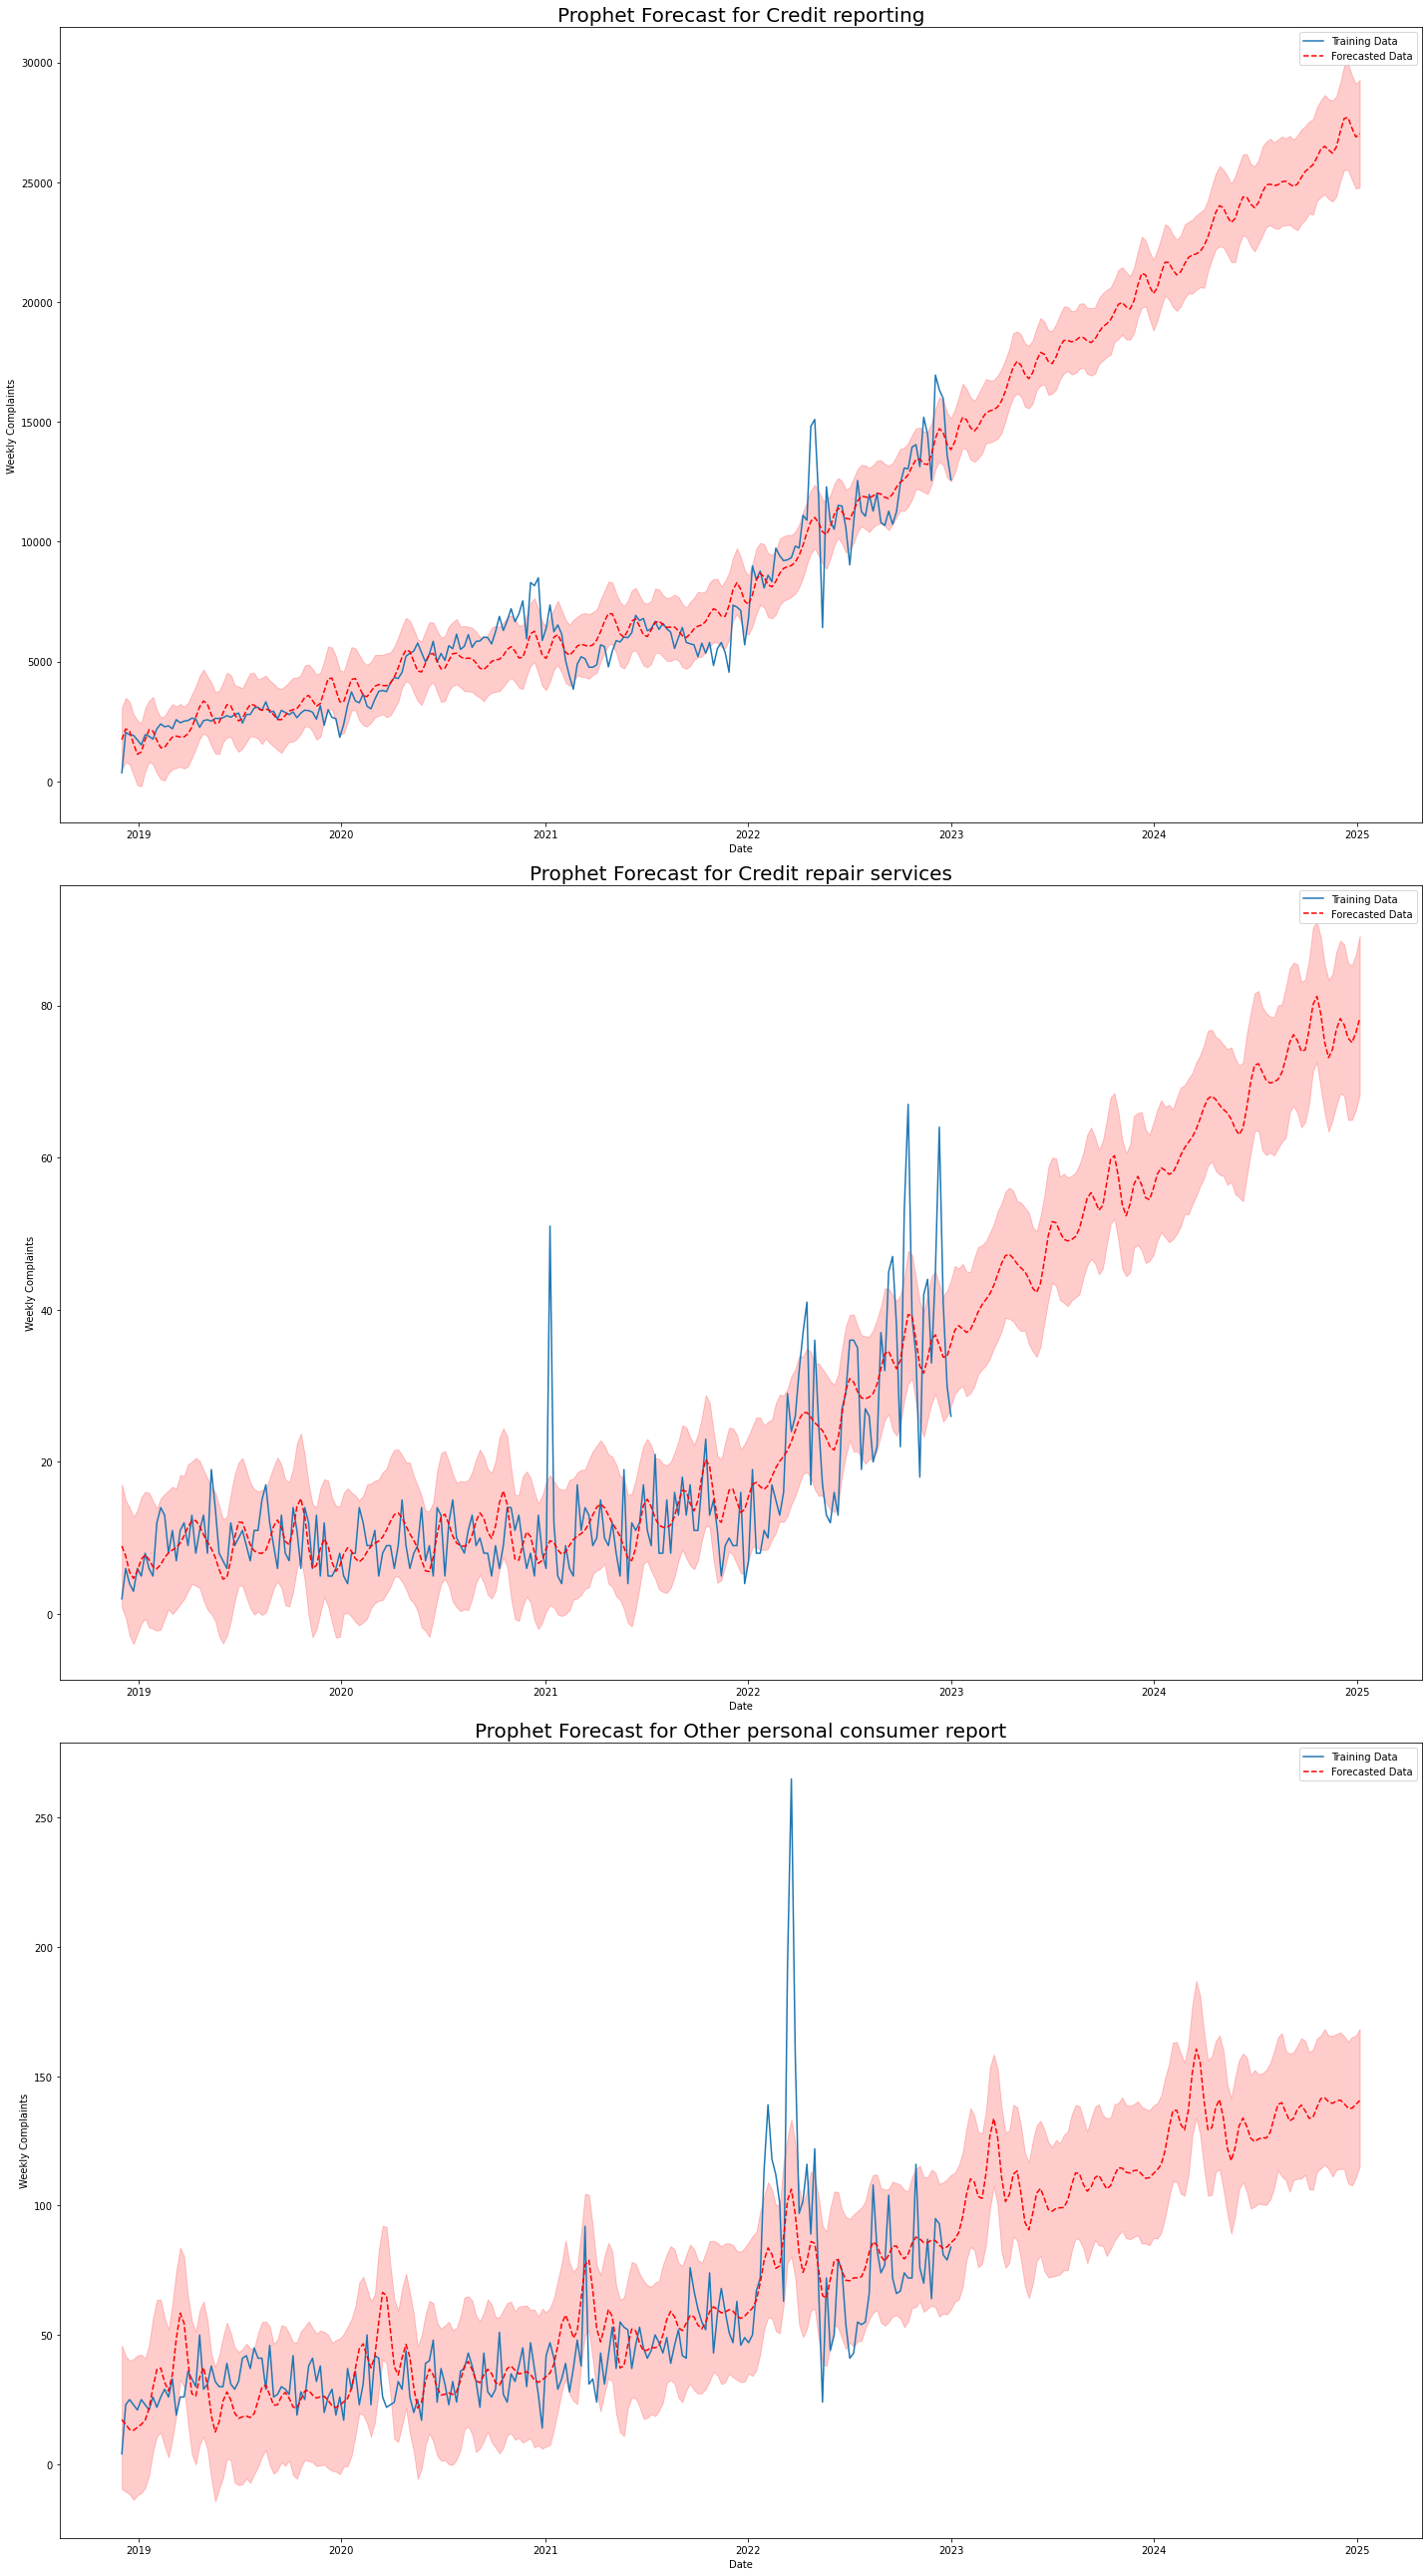

In [60]:
# Run the forecast for the 3 sub_products of "Credit reporting ..." due to its prevalance in the dataset

logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

# Filter for the main "Credit reporting" product and identify its sub-products
main_product = "Credit reporting, credit repair services, or other personal consumer reports"
sub_product_data = data[data['Product'] == main_product]
sub_product_types = sub_product_data['Sub.product'].unique()

fig, axs = plt.subplots(len(sub_product_types), 1, figsize=(20, 12 * len(sub_product_types)))
all_forecasts = pd.DataFrame()

for i, sub_product_type in enumerate(sub_product_types):
    filtered_data = sub_product_data[sub_product_data['Sub.product'] == sub_product_type]
    weekly_counts = filtered_data.resample('W', on='Date.received').size().reset_index(name='y')
    weekly_counts.rename(columns={'Date.received': 'ds'}, inplace=True)
    
    model_prophet = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
    model_prophet.fit(weekly_counts)
    
    periods_required = (datetime(2024, 12, 31) - weekly_counts['ds'].max()).days // 7 + 1
    future_dates = model_prophet.make_future_dataframe(periods=periods_required, freq='W')
    forecast = model_prophet.predict(future_dates)
    
    forecast['product'] = f"Credit reporting / {sub_product_type}"
    forecast_filtered = forecast[(forecast['ds'] >= '2023-01-01') & (forecast['ds'] <= '2024-12-31')].head(104)
    forecast_filtered['week'] = (forecast_filtered['ds'] - pd.to_timedelta(forecast_filtered['ds'].dt.weekday, unit='d')).dt.strftime('%Y-%m-%d')
    forecast_filtered = forecast_filtered[['week', 'yhat', 'yhat_lower', 'yhat_upper', 'product']]
    
    all_forecasts = pd.concat([all_forecasts, forecast_filtered], ignore_index=True)

    ax = axs[i]
    ax.plot(weekly_counts['ds'], weekly_counts['y'], label='Training Data')
    ax.plot(forecast['ds'], forecast['yhat'], label='Forecasted Data', color='red', linestyle='--')
    ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='red', alpha=0.2)
    ax.set_title(f'Prophet Forecast for {sub_product_type}', fontsize=20)
    ax.set_xlabel('Date')
    ax.set_ylabel('Weekly Complaints')
    ax.legend()

plt.tight_layout()
plt.show()

all_forecasts.to_csv('intermediate_forecasts2.csv', index=False)

In [61]:
forecasts_main = pd.read_csv('intermediate_forecasts.csv')
forecasts_sub = pd.read_csv('intermediate_forecasts2.csv')

final_forecasts = pd.concat([forecasts_main, forecasts_sub], ignore_index=True)

final_forecasts.to_csv('2023_2024_forecasts.csv', index=False)

In [15]:
# Cross-validation for these sub-product forecasts

from prophet.diagnostics import cross_validation, performance_metrics


prophet_df = product_data[['Date.received', 'Sub.product']].copy()
prophet_df.rename(columns={'Date.received': 'ds'}, inplace=True)
prophet_df['y'] = 1  
prophet_df = prophet_df.groupby('ds').count().reset_index() 

model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)

model.fit(prophet_df)
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon='365 days')


df_p = performance_metrics(df_cv)
average_performance = df_p.mean()

print(df_p)
print("\nAverage Performance Metrics:\n", average_performance)


  0%|          | 0/3 [00:00<?, ?it/s]

     horizon        mse      rmse       mae      mape     mdape     smape  \
0    36 days  56.007633  7.483825  5.570608  0.424646  0.367750  0.530842   
1    37 days  55.743677  7.466169  5.537843  0.413270  0.363018  0.523621   
2    38 days  56.540435  7.519337  5.644609  0.418273  0.363018  0.528224   
3    39 days  57.510823  7.583589  5.726144  0.418417  0.363018  0.534438   
4    40 days  57.461414  7.580331  5.685679  0.410456  0.338047  0.526539   
..       ...        ...       ...       ...       ...       ...       ...   
325 361 days  85.133729  9.226794  7.762601  0.942271  0.560031  0.909292   
326 362 days  85.925538  9.269603  7.759316  0.974075  0.560031  0.910661   
327 363 days  88.152380  9.388950  7.829420  0.972132  0.576686  0.919321   
328 364 days  86.682620  9.310350  7.754965  0.967983  0.560031  0.916341   
329 365 days  84.682084  9.202287  7.607758  0.954631  0.557073  0.895237   

     coverage  
0    0.740741  
1    0.740741  
2    0.731481  
3    0.7129